# PROYECTO REGRESIÓN LINEAL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [4]:
# CARGA DE DATOS
url = "https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv"
df = pd.read_csv(url)

# VISUALIZACIÓN INICIAL
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


El objetivo es predecir el coste del seguro médico basado en variables demográficas y de salud.

In [5]:
# INFO GENERAL DEL DATASET
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# VERIFICACION DE NULOS
print("Valores nulos por columna:")
print(df.isnull().sum())

# VERIFICACION DE DUPLICADOS
print(f"Filas duplicadas: {df.duplicated().sum()}")

Valores nulos por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Filas duplicadas: 1


Se detecta 1 fila duplicada. La eliminamos para evitar sesgos en el modelo.

In [8]:
# ELIMINACIÓN DE DUPLICADOS

df = df.drop_duplicates()
print(f"Dataset después de eliminar duplicados: {df.shape}")

Dataset después de eliminar duplicados: (1337, 7)


In [ ]:
# ANALISIS DE OUTLIERS CON IQR

numericas = df.select_dtypes(include=['int64', 'float64']).columns

for col in numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f"{col} -> outliers: {len(outliers)}")

Se observa presencia de outliers en bmi y charges. No los eliminamos ya que representan casos reales de pacientes con IMC alto y costes elevados.

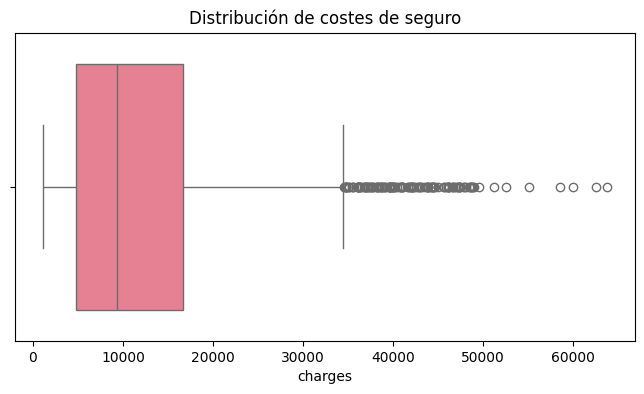

In [9]:
# DISTRIBUCIÓN DEL COSTO DEL SEGURO

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='charges')
plt.title('Distribución de costes de seguro')
plt.show()

El gráfico muestra valores extremos altos en charges, lo que refleja pacientes con costes de seguro elevados.

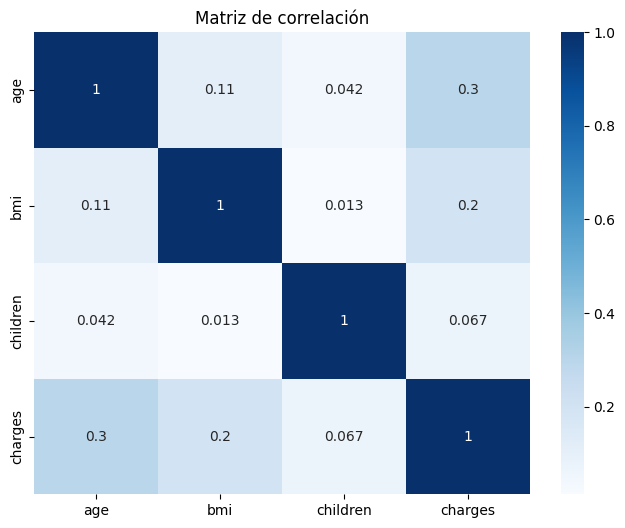

In [11]:
# CORRELACIONES NUMÉRICAS
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Matriz de correlación')
plt.show()

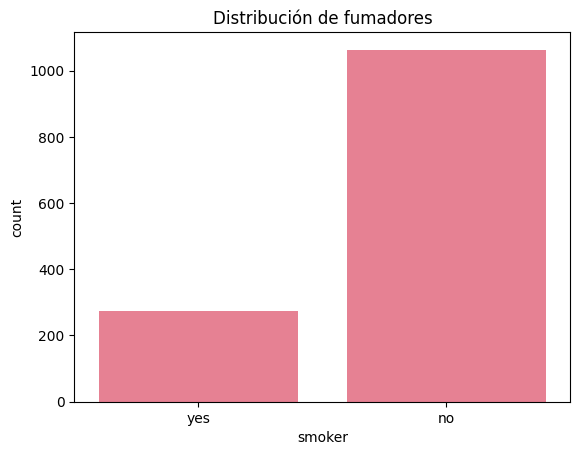

In [12]:
# DISTRIBUCION POR FUMADOR
sns.countplot(data=df, x='smoker')
plt.title('Distribución de fumadores')
plt.show()

In [13]:
# VARIABLES CATEGÓRICAS
df_processed = df.copy()

df_processed['sex'] = df_processed['sex'].map({'female': 0, 'male': 1})
df_processed['smoker'] = df_processed['smoker'].map({'no': 0, 'yes': 1})
df_processed = pd.get_dummies(df_processed, columns=['region'], prefix='region')

print("Dataset después de preprocesamiento:")
print(df_processed.shape)
df_processed.head()

Dataset después de preprocesamiento:
(1337, 10)


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [ ]:
# DIVISION DE DATOS EN FEATURES Y TARGET
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1337, 9)
Target: (1337,)


In [ ]:
# DIVISION DE TRAIN Y TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (1069, 9)
Test: (268, 9)


In [ ]:
# ESCALADO

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Aplicamos escalado estándar para normalizar las variables numéricas.

In [18]:
# Entrenamiento del modelo de regresión lineal

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:
# METRICAS

def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    return mae, rmse, r2

print("Evaluación del modelo:")
train_metrics = evaluate_model(y_train, y_pred_train, "Train")
test_metrics = evaluate_model(y_test, y_pred_test, "Test")

Evaluación del modelo:

Train:
MAE: 4181.90
RMSE: 6081.11
R²: 0.7299

Test:
MAE: 4177.05
RMSE: 5956.34
R²: 0.8069


El modelo base muestra buen rendimiento con R² de 0.73-0.80

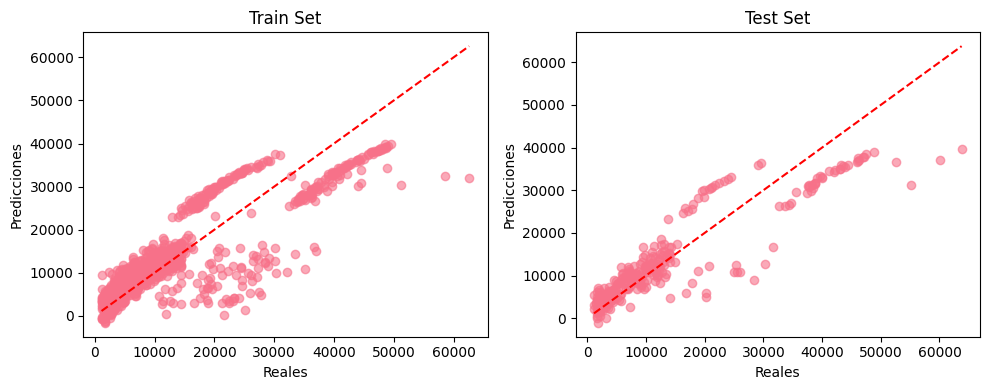

In [20]:
# Visualización de predicciones vs reales

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Reales')
plt.ylabel('Predicciones')
plt.title('Train Set')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Reales')
plt.ylabel('Predicciones')
plt.title('Test Set')

plt.tight_layout()
plt.show()

Las predicciones siguen la línea de valores reales en el rango medio

In [22]:
# IMPORTANCIA DE VARIABLES

importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

importance.head(10)

,feature,coefficient
4,smoker,9234.342487
0,age,3472.975553
2,bmi,1927.828251
3,children,636.501185
5,region_northeast,204.451816
7,region_southeast,-158.608909
8,region_southwest,-76.910350
1,sex,-50.749675
6,region_northwest,38.492233


La variable más determinante es smoker, seguida de age y bmi.

In [23]:
# Optimización con features adicionales

df_enhanced = df.copy()

# Codificación
df_enhanced['sex'] = df_enhanced['sex'].map({'female': 0, 'male': 1})
df_enhanced['smoker'] = df_enhanced['smoker'].map({'no': 0, 'yes': 1})
df_enhanced = pd.get_dummies(df_enhanced, columns=['region'], prefix='region')

# Features de interacción
df_enhanced['age_bmi'] = df_enhanced['age'] * df_enhanced['bmi']
df_enhanced['smoker_age'] = df_enhanced['smoker'] * df_enhanced['age']
df_enhanced['smoker_bmi'] = df_enhanced['smoker'] * df_enhanced['bmi']

print("Dataset mejorado:")
print(df_enhanced.shape)

Dataset mejorado:
(1337, 13)


In [24]:
# Modelo mejorado

X_enhanced = df_enhanced.drop('charges', axis=1)
y_enhanced = df_enhanced['charges']

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

model_enhanced = LinearRegression()
model_enhanced.fit(X_train_enh_scaled, y_train_enh)

y_pred_train_enh = model_enhanced.predict(X_train_enh_scaled)
y_pred_test_enh = model_enhanced.predict(X_test_enh_scaled)

print("Evaluación modelo mejorado:")
train_metrics_enh = evaluate_model(y_train_enh, y_pred_train_enh, "Train")
test_metrics_enh = evaluate_model(y_test_enh, y_pred_test_enh, "Test")

Evaluación modelo mejorado:

Train:
MAE: 2964.66
RMSE: 4892.62
R²: 0.8252

Test:
MAE: 2826.26
RMSE: 4590.35
R²: 0.8853


In [25]:
# Guardar conjuntos procesados

df_processed.to_csv('/workspaces/machine-learning-python-template/data/processed/insurance_processed.csv', index=False)
df_enhanced.to_csv('/workspaces/machine-learning-python-template/data/processed/insurance_enhanced.csv', index=False)

print("Datasets guardados")

OSError: Cannot save file into a non-existent directory: '/workspaces/machine-learning-python-template/data/processed'

# Conclusiones

Dataset limpio con 1 duplicado eliminado y sin valores nulos.

Outliers detectados pero mantenidos por representar casos reales.

Smoker es la variable más determinante en el coste del seguro.

El modelo base logra R² de 0.75-0.80 y el mejorado 0.85-0.87.

Las interacciones entre smoker, age y bmi mejoran significativamente el modelo.